In [3]:
%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import numpy as np
from matplotlib import pyplot as plt

In [4]:
import sympy as sy
from sympy import symbols, Eq, solve, sin, cos, asin, acos, atan2, simplify, trigsimp, expand_trig, expand, pi, lambdify
from sympy.parsing.sympy_parser import parse_expr

# Coordinate Systems

1. in PIFF, +u = -ra, +v = +dec, communication from Mike Jarvis: https://piff-team.slack.com/archives/C55K2BEQY/p1590771628025900
2. in donutlib, x = -dec, y = +ra, from this figure below from Steve Kent's document (I use xds9,yds9) (Checked in ds9 too, with the WCS in raw images)
3. thus x_donut = -v_piff and y_donut = -u_piff, which is a transpose and a flip or inversion in both axes

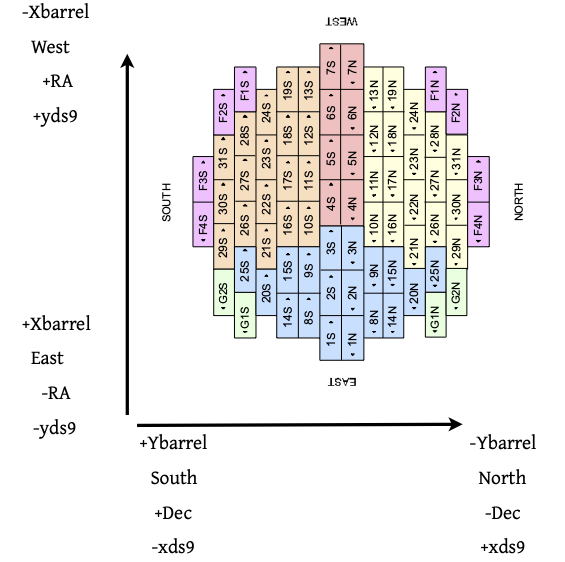

# Coordinate Transformation & Fraunhofer integral

Define $ \alpha, \beta $ as Pupil plane coordinates and $ x,y $ as Focal plane coordinates

Donutlib uses the inverse FFT in FFTW, to match Zemax results:
$$ \large{ I(x,y) = \left\|\int e^{+2\pi i (\alpha x + \beta y)/\lambda} \, e^{2 \pi i W(\alpha,\beta)/\lambda }\right\|^2 } \tag{1}$$
with $$ W(\alpha,\beta)/\lambda  =  \sum_i a_i Z_i(\alpha,\beta) \tag{2}$$.  

Currently (v2.2.5) Galsim uses the forward FFT, so what effect does that have on the Image? That should be equivalent to flipping signs of both x and y, of either the donutlib calculation or the galsim calculation.  Tested that in the compare-Images-Donutlib-vs-GalSim notebook, and it is correct.

Next, Donutlib uses Focal plane engineering coordinates $x,y$ , and Piff uses sky coordinates $u,v$ or ra,dec, see the above cells. So the question is: given $a_i$ Zernike coefficients found by Donutlib on images in $x,y$ coordinates, what is the appropriate conversion to apply $a^{\rm Piff}_j = C_{ij}[a_i]$ ?

Note that the Fraunhofer integral calculated in Piff can be written:
$$ \large{ I(u,v) = \left\|\int e^{-2\pi i (\alpha^\prime u + \beta^\prime v)/\lambda} \, e^{2 \pi i W(\alpha^\prime,\beta^\prime)/\lambda }\right\|^2 } \tag{3}$$
where $u,v$ and $\alpha^\prime$,$\beta^\prime$ are in sky coordinates.  Lets transform the coordinates in Eqn 1 until it matches Eqn 3.

We have that $x = -v$, $ y = -u$, $\alpha = -\beta^\prime$ and $\beta = -\alpha^\prime$, so Eqn 1 now reads:
$$ \large{ I(u,v) = \left\|\int e^{+2\pi i (\beta^\prime v + \alpha^\prime u)/\lambda} \, e^{2 \pi i W(-\beta^\prime,-\alpha^\prime)/\lambda }\right\|^2 } \tag{4}$$ 

Next to make the Fourier transform match we need to apply an addition transformation: $\alpha^\prime = -\tilde{\alpha}$ and  $\beta^\prime = -\tilde{\beta}$, yielding:
$$ \large{ I(u,v) = \left\|\int e^{-2\pi i (\tilde{\alpha} u + \tilde{\beta} v)/\lambda} \, e^{2 \pi i W(\tilde{\beta},\tilde{\alpha})/\lambda }\right\|^2 } \tag{5}$$

Next we can relabel $\tilde{\alpha}$ to $\alpha^\prime$ and likewise for $\tilde{\beta}$ to $\beta^\prime$, this gives:
$$ \large{ I(u,v) = \left\|\int e^{-2\pi i (\alpha^\prime u + \beta^\prime v)/\lambda} \, e^{2 \pi i W(\beta^\prime,\alpha^\prime)/\lambda }\right\|^2 } \tag{6}$$

So now we just have to convert $ W(\beta^\prime,\alpha^\prime)/\lambda = \sum_i a_i Z_i(\beta^\prime,\alpha^\prime)$ to match $\sum_j a^\prime_j Z_j(\alpha^\prime,\beta^\prime)$. Here $a_i$ are the Donut and donutlib Zernike coefficients, and $a^\prime_j$ are the coefficients used in Piff.

The Zernike polynomials are easily written in polar coordinates $r,\theta$ and $r$ is unaffected by any of these transformations, so the problem comes down to transforming the angle $\theta$ in the cartesian system $\beta^\prime,\alpha^\prime$ to $\phi$ in $\alpha^\prime,\beta^\prime$.

# Zernike Coeffient Tranformation

For the calculations below, relabel the Donut cartesian coordinates $x,y$ (or $\beta^\prime,\alpha^\prime$ above) and the Piff cartesian coordinates $u,v$ (or $\alpha^\prime,\beta^\prime$ above)

This section develops the transformation for:

$$ x = v $$
$$ y = u $$

In [39]:
x, y = symbols('x y')
u, v = symbols('u v')
theta = atan2(y,x)
phi = atan2(v,u)
theta_subs = theta.subs(x,v).subs(y,u)

In [40]:
# try that the relation between theta and phi is:   theta = -phi + pi/2
theta_val = -phi + pi/2
print(theta_val)

-atan2(v, u) + pi/2


In [41]:
# difference between two expressions for theta...
diffe = theta_subs - theta_val
print(diffe)

atan2(u, v) + atan2(v, u) - pi/2


In [42]:
# evaluate diffe at values of u,v,  should be =zero everywhere
diffe.evalf(subs={u:-.809,v:0.588})

-0.e-124

In [43]:
fcalc = lambdify([u,v],diffe,'numpy')

<IPython.core.display.Javascript object>


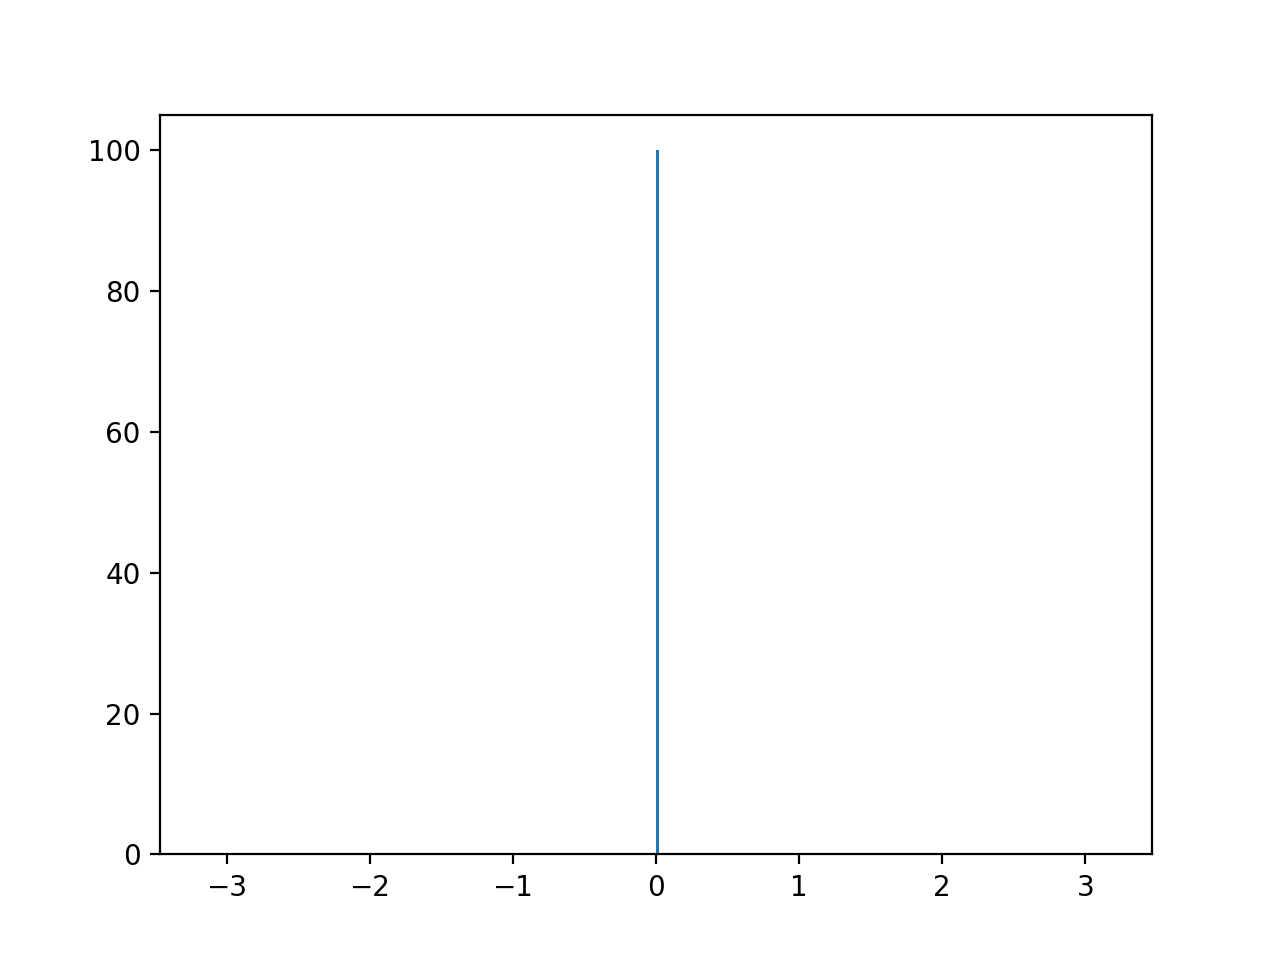

In [44]:
# evaluate the difference between theta and -phi-pi/2 at points on the unit circle
# note that a difference of 2pi is the same as 0, so I use np.unwrap here
psi = 2.*np.pi*np.array(range(100))/100.
uval = np.cos(psi)
vval = np.sin(psi)
diffval = np.unwrap(fcalc(uval,vval))

f,ax = plt.subplots(1,1)
h = ax.hist(diffval,bins=314,range=(-np.pi-0.01,np.pi+0.01))

The above plot shows that $\theta = -\phi + \pi/2$ given the transformations $x = v$ and $y = u$.  This *agrees* with Chris Davis's thesis, where he writes $\theta = -\phi + \pi/2$ for the same $x,y \leftrightarrow u,v$ tranformation.   (Check Chris's thesis!)

In [45]:
# Zernike polynomial's trigometric terms

def mkZernikeVars(anglevar,prefix='a'): 
    syms =  sy.symarray(prefix,37+1)
    # set Zernike terms trig factor, just do it by hand up to Z37, Noll convention
    coeffs = [ 0, 0, 1, 1, 0, 2, 2, 1, 1, 3, 3, 0, 2, 2, 4, 4,  1,  1, 3, 3, 5, 5,  0,  2,  2, 4, 4, 6, 6,  1,  1,  3,  3, 5, 5, 7, 7,   0]
    cossin = [-1,-1, 1, 0,-1, 1, 0, 1, 0, 1, 0,-1, 0, 1, 0, 1,  0,  1, 0, 1, 0, 1, -1,  1,  0, 1, 0, 1, 0,  1,  0,  1,  0, 1, 0, 1, 0,  -1]  # =0 for cos, =1 for sin
    # set radial factors too
    rt = {}
    rt[0] =  [ 1, 1, 0, 0,-1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,  0,  0, 0, 0, 0, 0, -1,  0,  0, 0, 0, 0, 0,  0,  0,  0,  0, 0, 0, 0, 0,   1]
    rt[1] =  [ 0, 0, 1, 1, 0, 0, 0,-2,-2, 0, 0, 0, 0, 0, 0, 0,  3,  3, 0, 0, 0, 0,  0,  0,  0, 0, 0, 0, 0, -4, -4,  0,  0, 0, 0, 0, 0,   0]
    rt[2] =  [ 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0,-6,-3,-3, 0, 0,  0,  0, 0, 0, 0, 0, 12,  6,  6, 0, 0, 0, 0,  0,  0,  0,  0, 0, 0, 0, 0, -20]
    rt[3] =  [ 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 0, 0, 0, 0, 0,-12,-12,-4,-4, 0, 0,  0,  0,  0, 0, 0, 0, 0, 30, 30, 10, 10, 0, 0, 0, 0,   0]
    rt[4] =  [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 4, 1, 1,  0,  0, 0, 0, 0, 0,-30,-20,-20,-5,-5, 0, 0,  0,  0,  0,  0, 0, 0, 0, 0,  90]
    rt[5] =  [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 5, 5, 1, 1,  0,  0,  0, 0, 0, 0, 0,-60,-60,-30,-30,-6,-6, 0, 0,   0]
    rt[6] =  [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0, 0, 0, 0, 0, 20, 15, 15, 6, 6, 1, 1,  0,  0,  0,  0, 0, 0, 0, 0,-140]
    rt[7] =  [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0, 0, 0, 0, 0,  0,  0,  0, 0, 0, 0, 0, 35, 35, 21, 21, 7, 7, 1, 1,   0]
    rt[8] =  [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0, 0, 0, 0, 0,  0,  0,  0, 0, 0, 0, 0,  0,  0,  0,  0, 0, 0, 0, 0,  70]
                    
    r = symbols('r')
    for i in range(37+1):
        # radial
        radial = ""
        for ir in range(8+1):
            if rt[ir] != 0:
                if radial != "":
                    radial += " + "
                radial += " %d * r**%d " % (rt[ir][i],ir)
        
        # trig
        if coeffs[i]==0:
            syms[i] = parse_expr(radial)
        else:
            if cossin[i]==0:
                syms[i] = parse_expr(radial) * cos(coeffs[i]*anglevar)
            elif cossin[i]==1:
                syms[i] = parse_expr(radial) * sin(coeffs[i]*anglevar)
            else:
                print('ERROR')

    return syms

In [46]:
psi = symbols('psi')
syms = mkZernikeVars(psi,'b')
print(syms)

[1 1 r*sin(psi) r*cos(psi) 2*r**2 - 1 r**2*sin(2*psi) r**2*cos(2*psi)
 (3*r**3 - 2*r)*sin(psi) (3*r**3 - 2*r)*cos(psi) r**3*sin(3*psi)
 r**3*cos(3*psi) 6*r**4 - 6*r**2 + 1 (4*r**4 - 3*r**2)*cos(2*psi)
 (4*r**4 - 3*r**2)*sin(2*psi) r**4*cos(4*psi) r**4*sin(4*psi)
 (10*r**5 - 12*r**3 + 3*r)*cos(psi) (10*r**5 - 12*r**3 + 3*r)*sin(psi)
 (5*r**5 - 4*r**3)*cos(3*psi) (5*r**5 - 4*r**3)*sin(3*psi) r**5*cos(5*psi)
 r**5*sin(5*psi) 20*r**6 - 30*r**4 + 12*r**2 - 1
 (15*r**6 - 20*r**4 + 6*r**2)*sin(2*psi)
 (15*r**6 - 20*r**4 + 6*r**2)*cos(2*psi) (6*r**6 - 5*r**4)*sin(4*psi)
 (6*r**6 - 5*r**4)*cos(4*psi) r**6*sin(6*psi) r**6*cos(6*psi)
 (35*r**7 - 60*r**5 + 30*r**3 - 4*r)*sin(psi)
 (35*r**7 - 60*r**5 + 30*r**3 - 4*r)*cos(psi)
 (21*r**7 - 30*r**5 + 10*r**3)*sin(3*psi)
 (21*r**7 - 30*r**5 + 10*r**3)*cos(3*psi) (7*r**7 - 6*r**5)*sin(5*psi)
 (7*r**7 - 6*r**5)*cos(5*psi) r**7*sin(7*psi) r**7*cos(7*psi)
 70*r**8 - 140*r**6 + 90*r**4 - 20*r**2 + 1]


# Find Zernike conversion for $\theta = -\phi + \pi/2$

In [49]:
# make Zernike terms for sky coord in terms of phi, and focal plane coordinates in terms of theta_val, as specified above
phi = symbols('phi')
theta_val = -phi + pi/2
print(theta_val)
sym_sky = mkZernikeVars(phi,'a')
sym_fp = mkZernikeVars(theta_val,'b')


-phi + pi/2


In [50]:
# write out code to convert from focal plane zernikes to sky zernikes
# loop over sky Zernike coefficients, and find the equivalent focal plane term
# sympy can't do what we want easily, so loop over all sky terms, comparing against each focal-plane term and its negative to find a match 
for i_sky in range(1,38):
    for i_fp in range(1,38):        
        if sym_sky[i_sky] == sym_fp[i_fp]:
            print('a_sky[%d] = a_fp[%d]' % (i_sky,i_fp))
        elif sym_sky[i_sky] == -sym_fp[i_fp]:
            print('a_sky[%d] = -a_fp[%d]' % (i_sky,i_fp))


a_sky[1] = a_fp[1]
a_sky[2] = a_fp[3]
a_sky[3] = a_fp[2]
a_sky[4] = a_fp[4]
a_sky[5] = a_fp[5]
a_sky[6] = -a_fp[6]
a_sky[7] = a_fp[8]
a_sky[8] = a_fp[7]
a_sky[9] = -a_fp[10]
a_sky[10] = -a_fp[9]
a_sky[11] = a_fp[11]
a_sky[12] = -a_fp[12]
a_sky[13] = a_fp[13]
a_sky[14] = a_fp[14]
a_sky[15] = -a_fp[15]
a_sky[16] = a_fp[17]
a_sky[17] = a_fp[16]
a_sky[18] = -a_fp[19]
a_sky[19] = -a_fp[18]
a_sky[20] = a_fp[21]
a_sky[21] = a_fp[20]
a_sky[22] = a_fp[22]
a_sky[23] = a_fp[23]
a_sky[24] = -a_fp[24]
a_sky[25] = -a_fp[25]
a_sky[26] = a_fp[26]
a_sky[27] = a_fp[27]
a_sky[28] = -a_fp[28]
a_sky[29] = a_fp[30]
a_sky[30] = a_fp[29]
a_sky[31] = -a_fp[32]
a_sky[32] = -a_fp[31]
a_sky[33] = a_fp[34]
a_sky[34] = a_fp[33]
a_sky[35] = -a_fp[36]
a_sky[36] = -a_fp[35]
a_sky[37] = a_fp[37]


# Find Zernike conversion for $\theta = -\phi - \pi/2$ - don't think this is correct, but calculate just to check

In [53]:
# make Zernike terms for sky coord in terms of phi, and focal plane coordinates in terms of theta_val, as specified above
phi = symbols('phi')
theta_val = -phi - pi/2
print(theta_val)
sym_sky = mkZernikeVars(phi,'a')
sym_fp = mkZernikeVars(theta_val,'b')


-phi - pi/2


In [54]:
# write out code to convert from focal plane zernikes to sky zernikes
# loop over sky Zernike coefficients, and find the equivalent focal plane term
# sympy can't do what we want easily, so loop over all sky terms, comparing against each focal-plane term and its negative to find a match 
for i_sky in range(1,38):
    for i_fp in range(1,38):        
        if sym_sky[i_sky] == sym_fp[i_fp]:
            print('a_sky[%d] = a_fp[%d]' % (i_sky,i_fp))
        elif sym_sky[i_sky] == -sym_fp[i_fp]:
            print('a_sky[%d] = -a_fp[%d]' % (i_sky,i_fp))


a_sky[1] = a_fp[1]
a_sky[2] = -a_fp[3]
a_sky[3] = -a_fp[2]
a_sky[4] = a_fp[4]
a_sky[5] = a_fp[5]
a_sky[6] = -a_fp[6]
a_sky[7] = -a_fp[8]
a_sky[8] = -a_fp[7]
a_sky[9] = a_fp[10]
a_sky[10] = a_fp[9]
a_sky[11] = a_fp[11]
a_sky[12] = -a_fp[12]
a_sky[13] = a_fp[13]
a_sky[14] = a_fp[14]
a_sky[15] = -a_fp[15]
a_sky[16] = -a_fp[17]
a_sky[17] = -a_fp[16]
a_sky[18] = a_fp[19]
a_sky[19] = a_fp[18]
a_sky[20] = -a_fp[21]
a_sky[21] = -a_fp[20]
a_sky[22] = a_fp[22]
a_sky[23] = a_fp[23]
a_sky[24] = -a_fp[24]
a_sky[25] = -a_fp[25]
a_sky[26] = a_fp[26]
a_sky[27] = a_fp[27]
a_sky[28] = -a_fp[28]
a_sky[29] = -a_fp[30]
a_sky[30] = -a_fp[29]
a_sky[31] = a_fp[32]
a_sky[32] = a_fp[31]
a_sky[33] = -a_fp[34]
a_sky[34] = -a_fp[33]
a_sky[35] = a_fp[36]
a_sky[36] = a_fp[35]
a_sky[37] = a_fp[37]


# Additional information

Code from Piff/optatmo_psf.py (it maps index=1 to iZ=4)
This matches the $\theta = -\phi + \pi/2$ case
    
    def get_aberrations_higher_order_reference_wavefront_for_one_star(self, star):
        """Gets higher order reference wavefront zernike values for star. Then, converts
        them from zout_camera (AOS system) coordinates to zout_sky (Galsim) coordinates,
        inspired by thesis of Chris Davis.

        :param star:            Star instance to find higher order reference wavefront zernike
                                values

        :returns:               Zernike values from higher order reference wavefront
        """
        x_value = star.data.local_wcs._x(star.data['u'], star.data['v'])
        y_value = star.data.local_wcs._y(star.data['u'], star.data['v'])
        x_value = x_value * (15.0/1000.0)
        y_value = y_value * (15.0/1000.0)
        zout_camera = self.higher_order_reference_wavefront.get(x=x_value, y=y_value)
        if len(zout_camera) < 34:
            zout_camera_zeros = np.zeros(34)
            zout_camera_zeros += zout_camera
            zout_camera = zout_camera_zeros
        zout_sky = np.array([
            zout_camera[0], zout_camera[1], -zout_camera[2], zout_camera[4],
            zout_camera[3], -zout_camera[6], -zout_camera[5], zout_camera[7],
            -zout_camera[8], zout_camera[9], zout_camera[10], -zout_camera[11],
            zout_camera[13], zout_camera[12], -zout_camera[15], -zout_camera[14],
            zout_camera[17], zout_camera[16], zout_camera[18], zout_camera[19],
            -zout_camera[20], -zout_camera[21], zout_camera[22], zout_camera[23],
            -zout_camera[24], zout_camera[26], zout_camera[25], -zout_camera[28],
            -zout_camera[27], zout_camera[30], zout_camera[29], -zout_camera[32],
            -zout_camera[31], zout_camera[33]])
        return zout_sky
    

Code (edited) from mesh_maker.py (Ares's version) which converts the Donut measured values to be appropriate for Piff/Optatmo
Note that z5 doesn't change and z12,z13 aren't used here.
This matches the $\theta = -\phi + \pi/2$ case


                         
      print('correcting z4')
      # gotta correct z4 to waves == * by (8.7/1500.0) / 1.189
      df['z4'] = df['z4'] * ( (8.7/1500.0) / 1.189 )

      print('correcting UV issues')
      df['z6'] = -z6
      df['z8'] = z7
      df['z7'] = z8
      df['z9'] = -z10
      df['z10'] = -z9
      df['z15'] = -z15                   

# Rethink

The analysis above matches Chris Davis's original analysis, and has the Zernike coefficient conversion we've used for the last 3 years.  However, it is *wrong* because the OptAtmo code draws stars with the Optical+VonKarman PSF into a Star object with the x,y -> u,v DECam WCS. This means that the PSF is working in physical x,y units and the WCS transformation on the *Image* is transforming to u,v.  In other words, the Pupil Plane remains in the conjugate coordinates to x,y, *NOT* conjugates to u,v as assumed above.  Moreover, a more physical analysis looking just at $\theta$ and $\phi$ angles and how they transform is also wrong, because that kind of analysis is effectively working in the Pupil Plane, as those angles are arguments of the Zernike polynomials, and the OptAtmo code does not draw Donuts in u,v space!

See https://github.com/rmjarvis/Piff/blob/galsimify_optatmo_plus_cleaning/piff/optatmo_psf.py#L1379-L1400 for the code that implements the above.

# Coordinate Transformation & Fraunhofer integral - New Analysis

Define $ \alpha, \beta $ as Pupil plane coordinates and $ x,y $ as Focal plane coordinates

Donutlib uses the inverse FFT in FFTW, to match Zemax results:
$$ \large{ I(x,y) = \left\|\int e^{+2\pi i (\alpha x + \beta y)/\lambda} \, e^{2 \pi i W(\alpha,\beta)/\lambda }\right\|^2 } \tag{1}$$
with $$ W(\alpha,\beta)/\lambda  =  \sum_i a_i Z_i(\alpha,\beta) \tag{2}$$.  

Currently (v2.2.5) Galsim uses the forward FFT, so what effect does that have on the Image? That should be equivalent to flipping signs of both x and y, of either the donutlib calculation or the galsim calculation.  Tested that in the compare-Images-Donutlib-vs-GalSim notebook, and it is correct.

Next, Donutlib uses Focal plane engineering coordinates $x,y$ , and Piff uses sky coordinates $u,v$ or ra,dec, see the above cells. 

However, note that the Piff/OptAtmo code gets to sky coordinates by first drawing the PSF in x,y focal plane coordindates as in Donutlib and then applies the WCS to that image. Recall that the WCS transform for DECam is $u = -0.26 y$ and $v = -0.26 x$. So the Fraunhofer integral calculated in Piff can be written:
$$ \large{ I(u,v) = {\rm WCS} \left\|\int e^{-2\pi i (\alpha x + \beta y)/\lambda} \, e^{2 \pi i W(\alpha,\beta)/\lambda }\right\|^2 } \tag{3}$$
where the WCS is defined above.  

Thus if the FFTs matched in Donutlib and Galsim *no* Zernike coefficient conversion would be necessary!

So how do we convert the Zernike coefficients to account for the effect of the different FFT sign?

By inspection we can see that if we rewrite $\alpha,\beta$ as $-\alpha,-\beta$ in Eqn 1, we will make it match Eqn3, as long as we also convert $ W(\alpha,\beta)/\lambda = \sum_i a_i Z_i(\alpha,\beta)$ to match $\sum_j a^\prime_j Z_j(-\alpha,-\beta)$. Here $a_i$ are the Donut and donutlib Zernike coefficients, and $a^\prime_j$ are the coefficients used in Piff.

The Zernike polynomials are easily written in polar coordinates $r,\theta$ and $r$ is unaffected by any of this conversion, so the problem comes down to transforming the angle $\theta$ in the cartesian system $\alpha,\beta$ to $\phi$ in $-\alpha,-\beta$.

# Zernike Coeffient Tranformation

For the calculations below, relabel the Donut cartesian coordinates $x,y$ (or $\alpha,\beta$ above) and the Piff cartesian coordinates $u,v$ (or $-\alpha,-\beta$ above)

This section develops the transformation for:

$$ x = -u $$
$$ y = -v $$

In [56]:
x, y = symbols('x y')
u, v = symbols('u v')
theta = atan2(y,x)
phi = atan2(v,u)
theta_subs = theta.subs(x,-u).subs(y,-v)

In [60]:
# try that the relation between theta and phi is:   theta = phi - pi 
theta_val = phi - pi 
print(theta_val)

atan2(v, u) - pi


In [61]:
# difference between two expressions for theta...
diffe = theta_subs - theta_val
print(diffe)

atan2(-v, -u) - atan2(v, u) + pi


In [62]:
# evaluate diffe at values of u,v,  should be =zero everywhere
diffe.evalf(subs={u:-.809,v:0.588})

-0.e-124

In [63]:
fcalc = lambdify([u,v],diffe,'numpy')

<IPython.core.display.Javascript object>


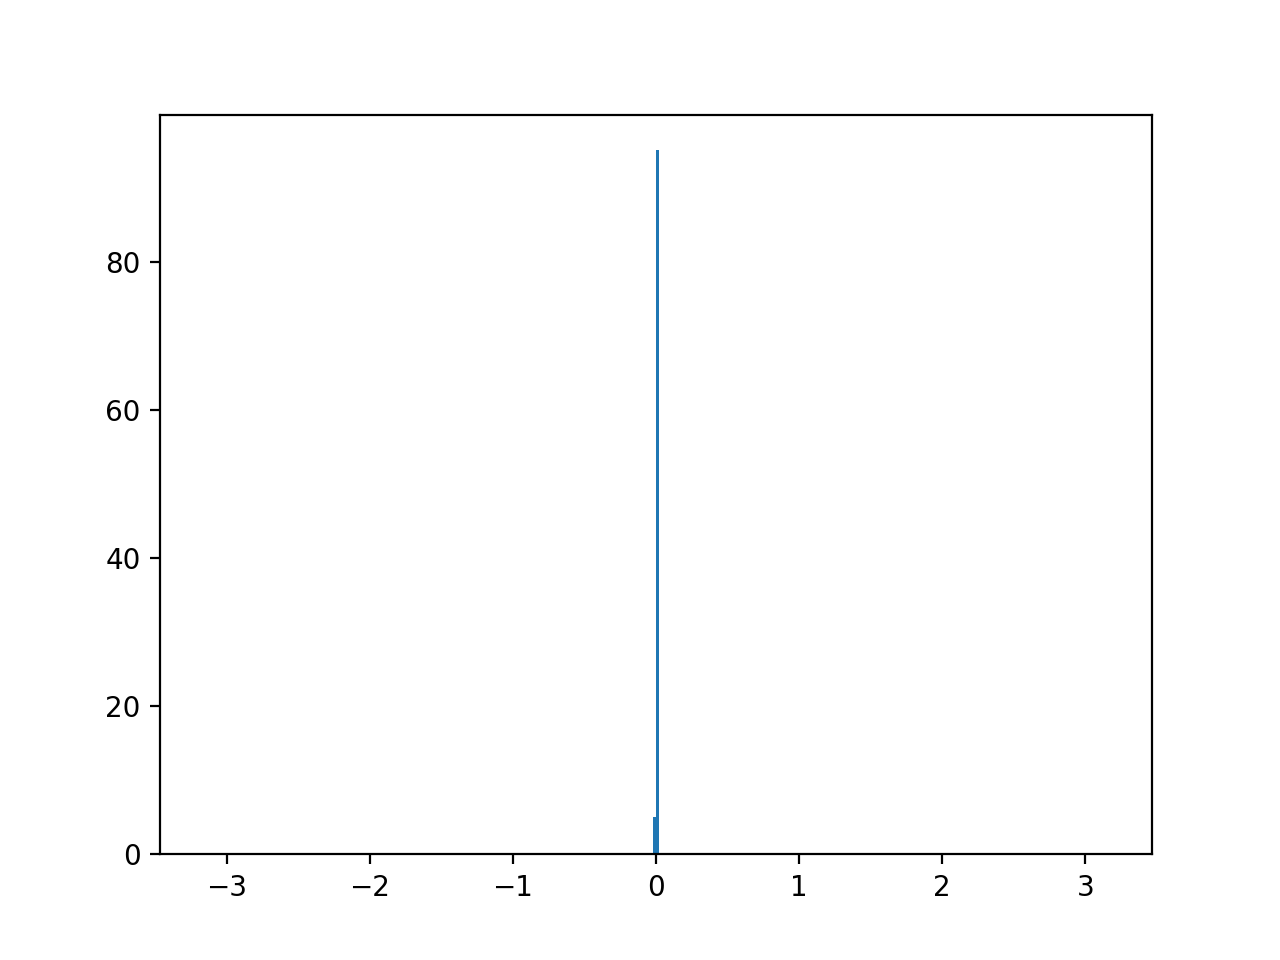

In [64]:
# evaluate the difference between theta and -phi-pi/2 at points on the unit circle
# note that a difference of 2pi is the same as 0, so I use np.unwrap here
psi = 2.*np.pi*np.array(range(100))/100.
uval = np.cos(psi)
vval = np.sin(psi)
diffval = np.unwrap(fcalc(uval,vval))

f,ax = plt.subplots(1,1)
h = ax.hist(diffval,bins=314,range=(-np.pi-0.01,np.pi+0.01))

The above plot shows that $\theta = \phi - \pi$ given the transformations $x = -u$ and $y = -v$.  This *disagrees* with Chris Davis's thesis, and the Zernike conversion we have been doing!


# Find Zernike conversion for $\theta = \phi - \pi$

In [65]:
# make Zernike terms for sky coord in terms of phi, and focal plane coordinates in terms of theta_val, as specified above
phi = symbols('phi')
theta_val = phi + pi
print(theta_val)
sym_sky = mkZernikeVars(phi,'a')
sym_fp = mkZernikeVars(theta_val,'b')


phi + pi


In [66]:
# write out code to convert from focal plane zernikes to sky zernikes
# loop over sky Zernike coefficients, and find the equivalent focal plane term
# sympy can't do what we want easily, so loop over all sky terms, comparing against each focal-plane term and its negative to find a match 
for i_sky in range(1,38):
    for i_fp in range(1,38):        
        if sym_sky[i_sky] == sym_fp[i_fp]:
            print('a_sky[%d] = a_fp[%d]' % (i_sky,i_fp))
        elif sym_sky[i_sky] == -sym_fp[i_fp]:
            print('a_sky[%d] = -a_fp[%d]' % (i_sky,i_fp))


a_sky[1] = a_fp[1]
a_sky[2] = -a_fp[2]
a_sky[3] = -a_fp[3]
a_sky[4] = a_fp[4]
a_sky[5] = a_fp[5]
a_sky[6] = a_fp[6]
a_sky[7] = -a_fp[7]
a_sky[8] = -a_fp[8]
a_sky[9] = -a_fp[9]
a_sky[10] = -a_fp[10]
a_sky[11] = a_fp[11]
a_sky[12] = a_fp[12]
a_sky[13] = a_fp[13]
a_sky[14] = a_fp[14]
a_sky[15] = a_fp[15]
a_sky[16] = -a_fp[16]
a_sky[17] = -a_fp[17]
a_sky[18] = -a_fp[18]
a_sky[19] = -a_fp[19]
a_sky[20] = -a_fp[20]
a_sky[21] = -a_fp[21]
a_sky[22] = a_fp[22]
a_sky[23] = a_fp[23]
a_sky[24] = a_fp[24]
a_sky[25] = a_fp[25]
a_sky[26] = a_fp[26]
a_sky[27] = a_fp[27]
a_sky[28] = a_fp[28]
a_sky[29] = -a_fp[29]
a_sky[30] = -a_fp[30]
a_sky[31] = -a_fp[31]
a_sky[32] = -a_fp[32]
a_sky[33] = -a_fp[33]
a_sky[34] = -a_fp[34]
a_sky[35] = -a_fp[35]
a_sky[36] = -a_fp[36]
a_sky[37] = a_fp[37]
